# Deep Deterministic Policy Gradient

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from collections import namedtuple, deque

In [2]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
from noise import OUNoise
from buffer import ReplayBuffer
from model import PolicyNetwork, ValueNetwork

In [4]:
import warnings
warnings.simplefilter('ignore', UserWarning)

In [5]:
plt.style.use('ggplot')

## Set Configs

In [6]:
is_cuda = torch.cuda.is_available()

if is_cuda: device = torch.device('cuda')
else: device = torch.device('cpu')

In [7]:
BUFFER_SIZE = int(1e6)
BATCH_SIZE = 128
GAMMA = 0.99
TAU = 1e-3
PRINT_EVERY = 100

# actor & critic network have different learning rates
LR_ACTOR = 1e-4
LR_CRITIC = 3e-4
WEIGHT_DECAY = 1e-4 # L2 weight decay

## Set Environment

In [8]:
ENV_NAME = 'BipedalWalker-v2'
env = gym.make(ENV_NAME).unwrapped; env.seed(90);

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [9]:
print('Environment Display:')
env.reset() # reset environment to a new, random state
env.render()

print('State space {}'.format(env.observation_space))
print('Action space {}'.format(env.action_space))

Environment Display:
State space Box(24,)
Action space Box(4,)


## Define [DDPG](https://arxiv.org/pdf/1509.02971.pdf) Agent

In [10]:
class DDPGAgent():
    """The Agent that will interacts with and learns from the environment."""
    
    def __init__(self, env, seed):
        """Initialize an Agent object."""
        
        self.env = env
        
        self.state_size = env.observation_space.shape[0]
        self.action_size = env.action_space.shape[0]
        
        self.gamma = GAMMA
        self.lr_actor = LR_ACTOR
        self.lr_critic = LR_CRITIC
        self.weight_decay = WEIGHT_DECAY
        self.tau = TAU
        
        # initialize actor and critic networks
        self.actor = PolicyNetwork(self.state_size, self.action_size, seed).to(device)
        self.actor_target = PolicyNetwork(self.state_size, self.action_size, seed).to(device)
        
        self.critic = ValueNetwork(self.state_size, self.action_size, seed).to(device)
        self.critic_target = ValueNetwork(self.state_size, self.action_size, seed).to(device)
            
        # set optimizers
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=self.lr_actor)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=self.lr_critic, weight_decay=self.weight_decay)
        
        # introduce noise process
        self.noise = OUNoise(self.action_size, seed)
        
        # set buffer
        self.buffer = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE, seed)
        
    def memorize(self, state, action, reward, next_state, done):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        
        self.buffer.add(state, action, reward, next_state, done)
    
        # if enough samples are available in memory, get random subset and learn
        if len(self.buffer) > BATCH_SIZE:
            experiences = self.buffer.sample()
            self.learn(experiences, self.gamma)
    
    def act(self, state, add_noise=True):
        """Return action for given state as per current policy."""
        
        state = torch.FloatTensor(state).to(device)
        self.actor.eval()
        with torch.no_grad():
            action = self.actor(state).cpu().data.numpy()
        self.actor.train()
        
        if add_noise==True:
            action += self.noise.sample()
        
        action = np.clip(action, -1, 1)
        
        return action
    
    def reset(self):
        """Reset noise parameters."""
        self.noise.reset()
        
    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples."""
        
        states, actions, rewards, next_states, dones = experiences
        
        # obtain Q expected
        Q_expected = self.critic(states, actions)
        
        # critic learns to evaluate the optimal value function by using the best actions predicted by actor
        next_actions = self.actor_target(next_states)
        Q_target_next = self.critic_target(next_states, next_actions)
        
        # compute Q target
        Q_targets = rewards + (gamma * Q_target_next * (1 - dones))
        
        # compute value loss
        value_loss = F.mse_loss(Q_targets.detach(), Q_expected)
        
        # minimize critic loss
        self.critic_optimizer.zero_grad()
        value_loss.backward()
        self.critic_optimizer.step()
        
        # update actor
        policy_loss = -self.critic(states, self.actor(states)).mean()
        
        # minimize policy loss
        self.actor_optimizer.zero_grad()
        policy_loss.backward()
        self.actor_optimizer.step()
        
        # softly update target networks
        self.soft_update(self.actor, self.actor_target, self.tau)
        self.soft_update(self.critic, self.critic_target, self.tau)
    
    def soft_update(self, local_model, target_model, tau):
        """Softly update model parameters."""
        
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(local_param.data * tau + target_param.data * (1.0 - tau))
            
    def save(self, actor_path, critic_path):
        """Save trained agent."""
        
        if not os.path.exists('./agents/'): os.makedirs('./agents/')
        torch.save(self.actor.state_dict(), actor_path); torch.save(self.critic.state_dict(), critic_path)
        
    def watch(self, num_episodes):
        """Watch trained agent."""
        
        for i_episode in range(1, num_episodes+1):
    
            state = env.reset()
            rewards = []
            for time_step in range(1000):

                env.render() # render the screen

                action = self.act(state) # select an action
                next_state, reward, done, _ = env.step(action)

                state = next_state
                rewards.append(reward)
                if done:
                    break

            print(f'\rEpisode: {i_episode}, Average Score: {sum(rewards):.2f}')

        env.close()

In [11]:
agent = DDPGAgent(env, seed=90)

## Train The Agent

In [ ]:
def train_agent(num_episodes=2000, max_time=700):
    
    scores = []
    scores_window = deque(maxlen=PRINT_EVERY)
    
    for i_episode in range(1, num_episodes+1):
        
        state = env.reset()
        agent.reset()
        
        score = 0
        for time_step in range(max_time):
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            
            agent.memorize(state, action, reward, next_state, done)
            state = next_state
            
            score += reward
            if done:
                break
                
        scores_window.append(score)
        scores.append(score)
        
        print(f'\rEpisode: {i_episode}, Average Score: {np.mean(scores_window):.2f}', end='')
        
        if i_episode % PRINT_EVERY == 0:
            print(f'\rEpisode: {i_episode}, Average Score: {np.mean(scores_window):.2f}')
        if np.mean(scores_window) >= 300.0:
            print(f'\nEnvironment solved in {i_episode:d} episodes! Average Score: {np.mean(scores_window):.2f}')
            break
            
    agent.save(f'./agents/ACTOR_{ENV_NAME}.pth', f'./agents/CRITIC_{ENV_NAME}.pth')
    print('Training completed.')
    
    return scores

In [ ]:
scores = train_agent(num_episodes=2000, max_time=700)

Episode: 100, Average Score: -95.20
Episode: 200, Average Score: -96.57
Episode: 300, Average Score: -101.10
Episode: 400, Average Score: -108.11
Episode: 500, Average Score: -102.16
Episode: 600, Average Score: -102.12
Episode: 700, Average Score: -101.23
Episode: 800, Average Score: -101.34
Episode: 900, Average Score: -109.41
Episode: 1000, Average Score: -96.55
Episode: 1100, Average Score: -114.11
Episode: 1200, Average Score: -96.342
Episode: 1300, Average Score: -105.32
Episode: 1400, Average Score: -96.825
Episode: 1500, Average Score: -117.22
Episode: 1600, Average Score: -123.42
Episode: 1700, Average Score: -118.86
Episode: 1800, Average Score: -111.88
Episode: 1900, Average Score: -125.27
Episode: 2000, Average Score: -122.89
Training completed.


## Evaluate The Agent

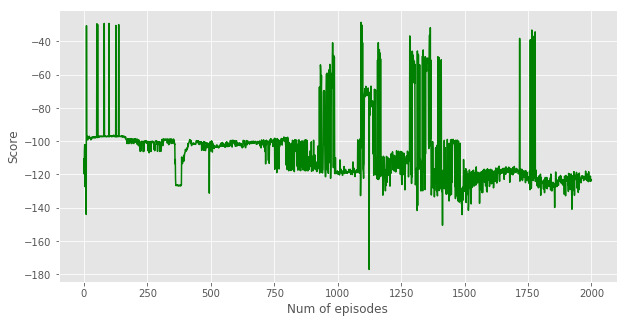

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(len(scores)), scores, color='green')
plt.xlabel('Num of episodes')
plt.ylabel('Score')
if not os.path.exists('./images/'): os.makedirs('./images/')
plt.savefig('./images/plot_of_ddpg_evaluation.png')
plt.show()

## 🎬 Watch The Smart Agent

In [ ]:
agent.actor.load_state_dict(torch.load(f'./agents/ACTOR_{ENV_NAME}.pth'));

In [ ]:
agent.watch(num_episodes=10)

Episode: 1, Average Score: -123.60
Episode: 2, Average Score: -126.92
Episode: 3, Average Score: -124.65
Episode: 4, Average Score: -132.11
Episode: 5, Average Score: -106.43
Episode: 6, Average Score: -125.85
Episode: 7, Average Score: -122.24
Episode: 8, Average Score: -103.40
Episode: 9, Average Score: -124.98
Episode: 10, Average Score: -126.47


---